# Crossentropy Algorithm
### Tested on Taxi-v3 from OpenAI Gym

In [11]:
#Imports
import gym
import numpy as np

In [12]:
#Load environement
env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [13]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states, n_actions))

n_states=500, n_actions=6


## Algorithm details - 
#### 1. Initialize a probability distribution over the action and state space. Initialized uniformly

```policy[s,a] = P(take action a | in state s)```
   
i.e. a 2D matrix with rows representing different states and cols for different actions


In [16]:
def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions))/n_actions
    return policy

policy = initialize_policy(n_states, n_actions)
# print(policy)

#### 2. Given a state s, the agent chooses the action a according to the probability distribution given in the policy

In [15]:
def generate_session(env, policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        
        #Given current state and the action space, select the action based on policy
        #Policy actions for the current state s
        act_for_s = policy[s]
        
        #Now select a according to this probability distribution
        a = np.random.choice(n_actions, p = act_for_s)   
        
        new_s, r, done, info = env.step(a)

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break

    return states, actions, total_reward

In [17]:
s, a, r = generate_session(env, policy)

The cell below gives the reward distribution with this uniformly initialized policy

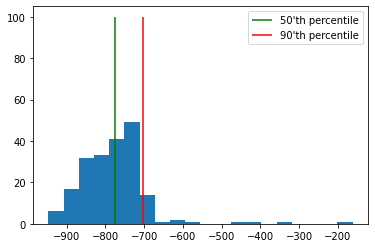

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

#### 3. After running on given policy, select the best(or elite) sessions

In [21]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Given the batch of states, actions and rewards,
    Select the sessions for which rewards >= threshold
    These are the elite sessions and will be used to update policy
    """
    #First find the reward threshold
    reward_threshold = np.percentile(rewards_batch, percentile)
    #Get all the elite sessions
    elite_sessions = np.where(rewards_batch >= reward_threshold)[0]
    #Go through all elite sessions and append the states and actions into lists
    elite_states = []
    elite_actions = []
    
    for sess in elite_sessions:
        for state in states_batch[sess]:
            elite_states.append(state)
        for action in actions_batch[sess]:
            elite_actions.append(action)

    return elite_states, elite_actions

#### 4. Using the elite sessions, update policy based on the number of times the action was taken at a given state in the elite sessions.

```policy[s_i, a_i] = #[occurences of si and ai in elite states/actions]/#[occurances of si in elite states]```

Basically, if an action is taken a lot of times when the agent was in the given state and this leads to an elite session i.e. more rewards, this should be done more by the policy. So, increase this probability

In [23]:
def update_policy(elite_states, elite_actions):
    """
    Using the elite sessions, update the policy on the best actions
    for the states it occurs in.
    If a state is not an elite state, set the actions to uniform
    If state was elite, update policy and normalize
    """
    #Initialize with uniform distribution
    new_policy = np.zeros([n_states, n_actions])

    for state, action in zip(elite_states, elite_actions):
        #For each elite state-action pair, increase the occurance number
        new_policy[state, action] += 1
    
    #Normalization procedure
    #For each other state not in elite_states set to 1/n_actions
    for state in range(n_states):
        if state not in elite_states:
            new_policy[state] = np.ones([1,n_actions])/n_actions
        #If the state in elite state, get the average
        else:
            new_policy[state] = new_policy[state]/np.sum(new_policy[state])

    return new_policy

# Training loop
Generate sessions, select N best and fit to those.

In [25]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [26]:
#reset policy just in case
policy = initialize_policy(n_states, n_actions)

mean reward = -34.404, threshold=6.000


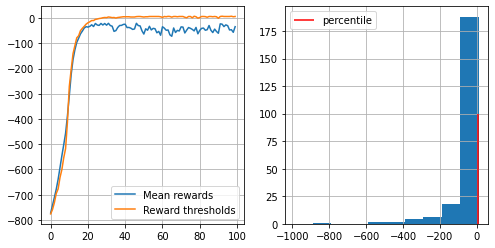

In [27]:
n_sessions = 250     # sample this many sessions
percentile = 50      # take this percent of session with highest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for i in range(100):
    #1.2.  Generate sessions using current policy
    %time sessions = [generate_session(env, policy) for session in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    #3. Get elite sessions
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    #4. Update policy based on elite sessions
    new_policy = update_policy(elite_states, elite_actions)
    #4-extra. Smooth updates actually
    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)

In [28]:
#Display
total_reward = 0.
s = env.reset()

for t in range(1000):
    #sample action from policy
    a = np.random.choice(n_actions, p=policy[s])
    new_s, r, done, info = env.step(a)
    env.render()
    total_reward += r

    s = new_s
    if done:
        break
print("Total Reward: ", total_reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y|